# GlucForecast: Predictive Modeling for Glucose Levels

In [1]:
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statistics
import tensorflow as tf

In [3]:
test_data = pd.read_csv("/content/adolescent#001-test-processed.csv", index_col=False)
train_data = pd.read_csv("/content/adolescent#001-train-processed.csv", index_col=False)
# train_data2 = pd.read_csv("/content/adolescent#002-train-processed.csv", index_col=False)

# train_data_ = pd.read_csv("/content/adolescent#001-train.csv", index_col=False)
# test_data_ = pd.read_csv("/content/adolescent#001-test.csv", index_col=False)



print('Data Impoted!!!!')

Data Impoted!!!!


In [4]:
train_data.head(10)

,Time,BG,Date,Hour
0,2019-05-01 00:00:00,149.020000,2019-05-01,0
1,2019-05-01 00:03:00,149.020000,2019-05-01,0
2,2019-05-01 00:06:00,149.020000,2019-05-01,0
3,2019-05-01 00:09:00,149.020000,2019-05-01,0
4,2019-05-01 00:12:00,149.020000,2019-05-01,0
5,2019-05-01 00:15:00,149.020000,2019-05-01,0
6,2019-05-01 00:18:00,149.020000,2019-05-01,0
7,2019-05-01 00:21:00,149.020000,2019-05-01,0
8,2019-05-01 00:24:00,149.020001,2019-05-01,0
9,2019-05-01 00:27:00,149.020002,2019-05-01,0


In [ ]:
train_data.describe()

,BG,Hour
count,36480.000000,36480.000000
mean,147.608681,11.500000
std,25.096764,6.922281
min,56.745486,0.000000
25%,130.980448,5.750000
50%,146.533674,11.500000
75%,165.399165,17.250000
max,236.990454,23.000000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36480 entries, 0 to 36479
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    36480 non-null  object 
 1   BG      36480 non-null  float64
 2   Date    36480 non-null  object 
 3   Hour    36480 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


<ipython-input-189-80546334946c>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_data_from_cap_processed = train_data.corr()


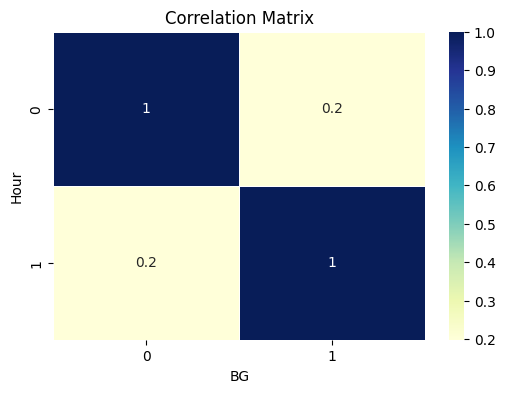

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Define the correlation matrix
corr_data_from_cap_processed = train_data.corr()
correlation_matrix = np.array(corr_data_from_cap_processed)

# Create a heatmap plot
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True,linewidths=.5,cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.xlabel('BG')
plt.ylabel('Hour')
plt.show()

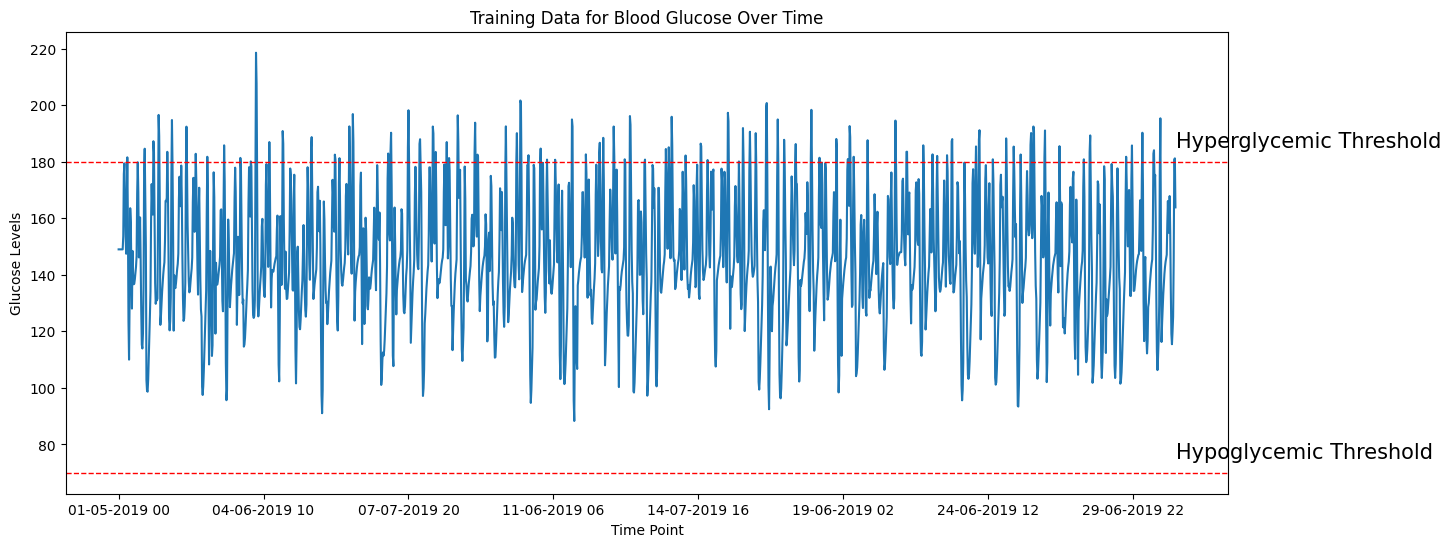

Beginning date for train_means
Time
01-05-2019 00    149.0
Name: BG, dtype: float64
**********************************
Ending date for train_means
Time
31-05-2019 23    163.85
Name: BG, dtype: float64


In [4]:
# Group BG levels by Date and Hour in both df.  means is a Series object.
train_data.Time = pd.to_datetime(train_data.Time,dayfirst=True).dt.strftime('%d-%m-%Y %H')
train_data.BG = train_data.BG.astype(int)

train_means = train_data['BG'].groupby([train_data.Time]).mean()


# Plot means for training set
plt.figure(figsize=(15,6))
train_means.plot(kind='line', title='Training Data for Blood Glucose Over Time')
plt.xlabel('Time Point')
plt.ylabel('Glucose Levels')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.text(len(train_means),185,'Hyperglycemic Threshold',size=15)
plt.text(len(train_means),75,'Hypoglycemic Threshold',size=15)
plt.show()

print('Beginning date for train_means')
print(train_means[[0]])
print('**********************************')
print('Ending date for train_means')
print(train_means[[len(train_means) - 1]])


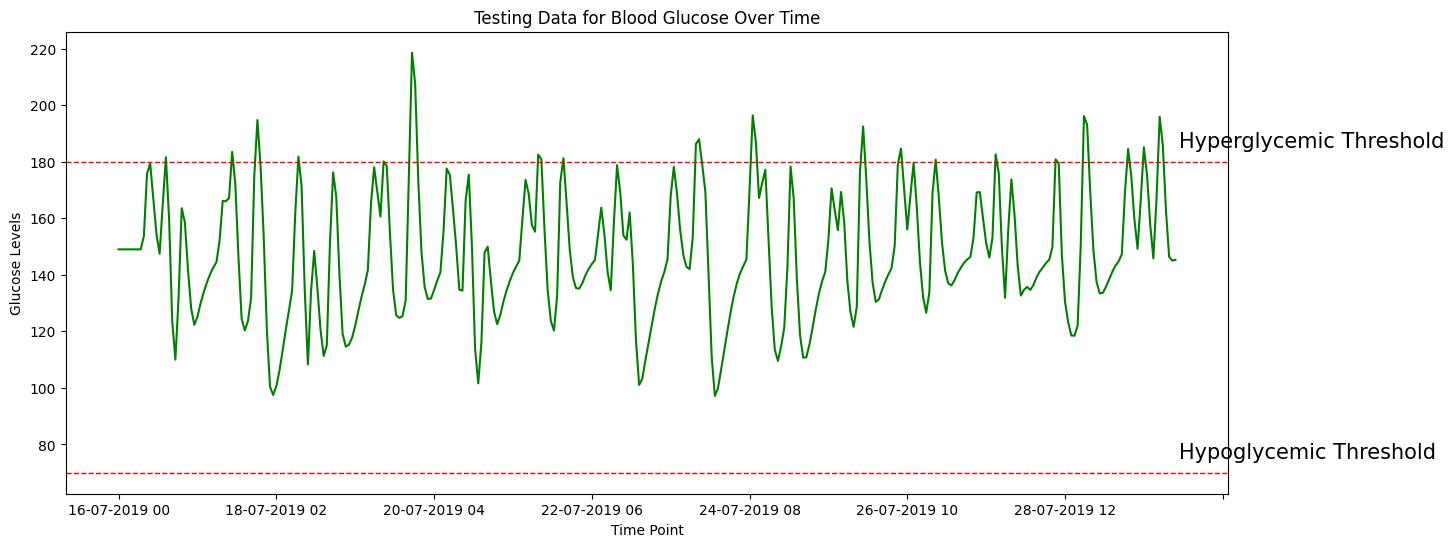

Beginning date for test_means
Time
16-07-2019 00    149.0
Name: BG, dtype: float64
Ending date for test_means
Time
29-07-2019 23    145.3
Name: BG, dtype: float64


In [5]:
# Group BG levels by Date and Hour in both df.  means is a Series object.
test_data.Time = pd.to_datetime(test_data.Time,dayfirst=True).dt.strftime('%d-%m-%Y %H')
test_data.BG = train_data.BG.astype(int)
test_means = test_data['BG'].groupby([test_data.Time]).mean()

# Plot means for testing set
plt.figure(figsize=(15,6))
test_means.plot(kind='line', color='green', title='Testing Data for Blood Glucose Over Time' )
plt.xlabel('Time Point')
plt.ylabel('Glucose Levels')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.text(len(test_means),185,'Hyperglycemic Threshold',size=15)
plt.text(len(test_means),75,'Hypoglycemic Threshold',size=15)
plt.show()

print('Beginning date for test_means')
print(test_means[[0]])
print('Ending date for test_means')
print(test_means[[len(test_means) - 1]])

In [ ]:
t = train_means.index[[0][0]]
str(t)

'01-05-2019 00'

In [6]:
# Add each element of train_means to train_glucose_df
train_glucose_df = pd.DataFrame(columns=['TimeStep', 'Glucose_Level'])
for i in range(0, len(train_means)):
  temp_date = train_means.index[[i][0]]
  temp_date_hour = str(temp_date)
  train_glucose_level = train_means[[i][0]]
  train_glucose_df.loc[len(train_glucose_df)] = [temp_date_hour, train_glucose_level]

# Add each element of test_means to train_glucose_df

test_glucose_df = pd.DataFrame(columns=['TimeStep', 'Glucose_Level'])
for i in range(0, len(test_means)):
  temp_date = test_means.index[[i][0]]
  temp_date_hour = str(temp_date)
  test_glucose_level = test_means[[i][0]]
  test_glucose_df.loc[len(test_glucose_df)] = [temp_date_hour, test_glucose_level]

train_glucose_df

,TimeStep,Glucose_Level
0,01-05-2019 00,149.00
1,01-05-2019 01,149.00
2,01-05-2019 02,149.00
3,01-05-2019 03,149.00
4,01-05-2019 04,149.00
...,...,...
1819,31-05-2019 19,125.10
1820,31-05-2019 20,145.15
1821,31-05-2019 21,180.70
1822,31-05-2019 22,181.20


In [ ]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler

# Feature
glucose_training_features = train_glucose_df.iloc[:,1:2].values

# Feature scaling
scaler = MinMaxScaler(feature_range = (0,1))
glucose_training_set_scaled = scaler.fit_transform(glucose_training_features)

# Feature
test_glucose_df_features = test_glucose_df.iloc[:,1:2].values


# Feature scaling
scaler = MinMaxScaler(feature_range = (0,1))
glucose_testing_set_scaled = scaler.fit_transform(test_glucose_df_features)

glucose_training_set_scaled

array([[0.46602687],
       [0.46602687],
       [0.46602687],
       ...,
       [0.70940499],
       [0.71324376],
       [0.58003839]])

In [ ]:
# Create Sequences with timestep 180 min ==> 3h
train_record_number = 1824
test_record_number = 396

features_set = []
labels = []

for i in range(60, train_record_number):
    features_set.append(glucose_training_set_scaled[i-60:i, 0])
    labels.append(glucose_training_set_scaled[i, 0])

features_set_test = []

for i in range(60, test_record_number):
    features_set_test.append(glucose_training_set_scaled[i-60:i, 0])
    # labels.append(glucose_training_set_scaled[i, 0])

print("features shape : ",len(features_set))
print("features shape : ",len(features_set_test))

features shape :  1764
features shape :  336


In [ ]:
# Reshape training set

features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

features_set_test = np.array(features_set_test)
features_set_test = np.reshape(features_set_test, (features_set_test.shape[0], features_set_test.shape[1], 1))

print("features shape : ",features_set.shape)
print("features shape : ",features_set_test.shape)

features shape :  (1764, 60, 1)
features shape :  (336, 60, 1)


In [ ]:
!pip install Tensorboard

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard

lr_sc=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=500,decay_rate=.7)
adamm=keras.optimizers.Adam(learning_rate=lr_sc)

# creat log folder
log_dir = os.path.join('Logs')
TB_callback = TensorBoard(log_dir=log_dir)

# callback for earlyStopping
Earlystopping_callback = EarlyStopping(verbose=1, patience=100)


In [ ]:
# Build LSTM model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))  # Two units (class Cases and Deaths)

model.compile(optimizer = adamm, loss = 'mean_squared_error', metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
from keras.callbacks import EarlyStopping

model.fit(features_set, labels, epochs = 100, batch_size = 32, callbacks = [Earlystopping_callback,TB_callback])

print('Model Trained!!!')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_dir}

In [ ]:
# evaluate the model
loss, acc = model.evaluate(features_set, labels, verbose=1)
print('Train Accuracy: %.3f' % acc)
print('Train Loss: %.3f' % loss)

# Save model
model.save(model_file)

In [ ]:
# Concat train and test to be able to do run testing

glucose_total = pd.DataFrame(columns=['Glucose_Level'])

glucose_total = pd.concat((train_glucose_df['Glucose_Level'], test_glucose_df['Glucose_Level']), axis=0)

glucose_total

0      149.00
1      149.00
2      149.00
3      149.00
4      149.00
        ...  
331    185.85
332    162.85
333    146.40
334    145.00
335    145.30
Name: Glucose_Level, Length: 2160, dtype: float64

In [ ]:
# Process testing Data for Make prediction

test_inputs = glucose_total[len(train_glucose_df) - 60:].values

test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

test_features = []
test_lable=[]
for i in range(60, test_record_number):
    test_features.append(test_inputs[i-60:i, 0])
    test_lable.append(test_inputs[i, 0])

test_features, test_lable= np.array(test_features) , np.array(test_lable)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))


print("test features shape : ",test_features.shape)

test features shape :  (336, 60, 1)


In [ ]:
len(train_glucose_df) - 60

1764

In [ ]:
len(glucose_total)- 1764

396

In [ ]:
# Make Predictions

model = load_model('/content/Model_Metadata_60.h5')

predictions = model.predict(features_set_test)


#Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

actual_predicted_difference_list = []

for i in range(0,len(predictions)):
    print('\nActual value for ' + str(test_glucose_df.loc[i,'TimeStep']) + ' = ' + str(test_glucose_df.loc[i,'Glucose_Level']))
    # print('\nPredicted value for ' + str(test_lable.loc[i,'TimeStep']) + ' = ' + str(predictions[i,0]))

    print('Predicted value = {0}'.format(predictions[i,0]))

    # Calculate mean square error
    actual_predicted_difference_list.append((predictions[i,0] - test_glucose_df.loc[i,'Glucose_Level']) ** 2)

mean_square = statistics.mean(actual_predicted_difference_list)
print('Mean square error = ' + str(mean_square))




11/11 [==============================] - 2s 8ms/step

Actual value for 16-07-2019 00 = 149.0
Predicted value = 170.4193878173828

Actual value for 16-07-2019 01 = 149.0
Predicted value = 180.3180389404297

Actual value for 16-07-2019 02 = 149.0
Predicted value = 163.1089324951172

Actual value for 16-07-2019 03 = 149.0
Predicted value = 146.09140014648438

Actual value for 16-07-2019 04 = 149.0
Predicted value = 137.8316650390625

Actual value for 16-07-2019 05 = 149.0
Predicted value = 141.8109130859375

Actual value for 16-07-2019 06 = 149.0
Predicted value = 150.74105834960938

Actual value for 16-07-2019 07 = 149.0
Predicted value = 146.20237731933594

Actual value for 16-07-2019 08 = 153.65
Predicted value = 162.9681854248047

Actual value for 16-07-2019 09 = 175.65
Predicted value = 196.88511657714844

Actual value for 16-07-2019 10 = 179.4
Predicted value = 189.49818420410156

Actual value for 16-07-2019 11 = 167.1
Predicted value = 164.4678192138672

Actual value for 16-07-2019

In [ ]:
test_glucose_df['Predected'] = predictions
test_glucose_df

,TimeStep,Glucose_Level,Predected
0,16-07-2019 00,149.00,170.419388
1,16-07-2019 01,149.00,180.318039
2,16-07-2019 02,149.00,163.108932
3,16-07-2019 03,149.00,146.091400
4,16-07-2019 04,149.00,137.831665
...,...,...,...
331,29-07-2019 19,185.85,155.544998
332,29-07-2019 20,162.85,165.782303
333,29-07-2019 21,146.40,179.644653
334,29-07-2019 22,145.00,167.341904



Begin Part 19 of 19 - Plot predictions


Plotting predictions


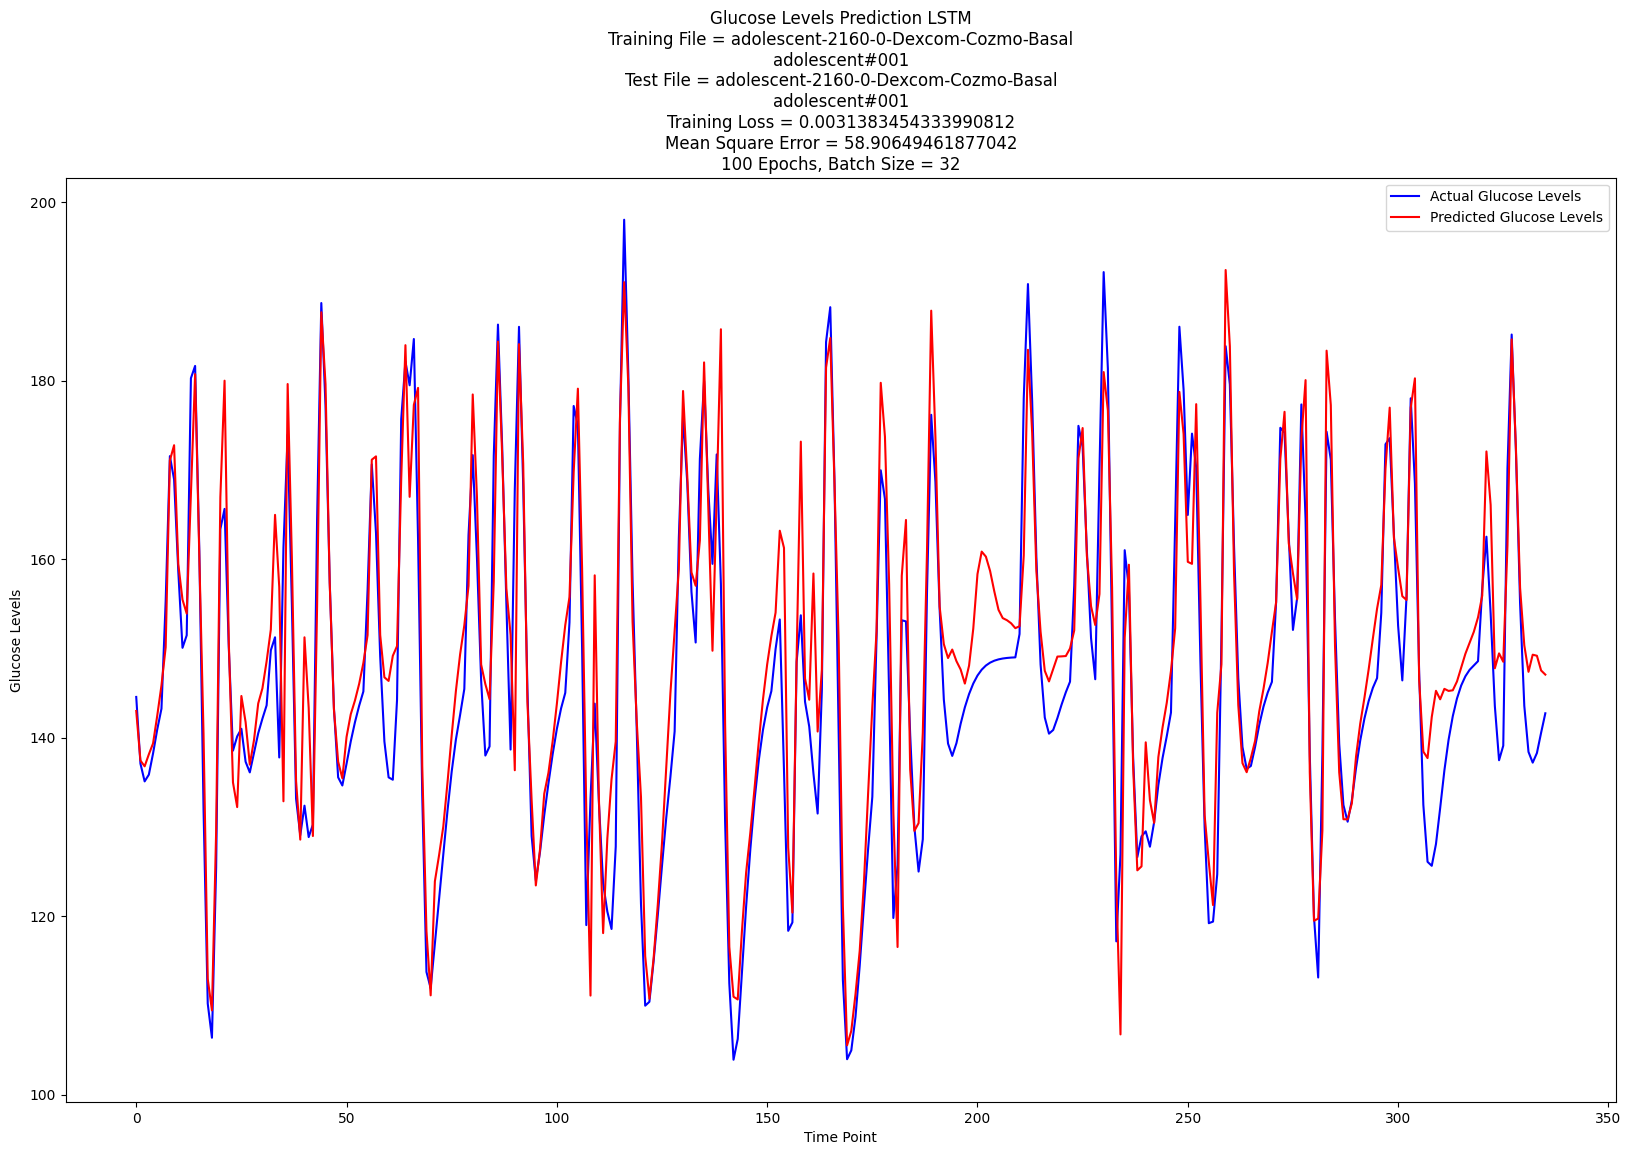

In [ ]:
actual = test_glucose_df['Glucose_Level'].values
actual = actual[0:len(test_glucose_df)]

print('\n\nPlotting predictions')
plt.figure(figsize=(20,12))
plt.plot(actual, color='blue', label='Actual Glucose Levels')
plt.plot(predictions , color='red', label='Predicted Glucose Levels')
plt.title('Glucose Levels Prediction LSTM\nTraining File = adolescent-2160-0-Dexcom-Cozmo-Basal\n' + input_train_file_name_prefix
          + '\nTest File = adolescent-2160-0-Dexcom-Cozmo-Basal\n' + input_test_file_name_prefix + '\nTraining Loss = ' +
         str(loss) + '\nMean Square Error = ' + str(mean_square) + '\n' + str(num_epochs) + ' Epochs, ' +
         'Batch Size = ' + str(training_batch_size))
plt.xlabel('Time Point')
plt.ylabel('Glucose Levels')
plt.legend()
plt.show()





In [ ]:
print('Training Loss = ' + str(loss))
print('Mean Square Error = ' + str(mean_square))

Training Loss = 0.0031383454333990812
Mean Square Error = 58.90649461877042


Test the model On New data

In [7]:
# Feature
test_glucose_df_features = test_glucose_df.iloc[7:15,1:2].values


# Feature scaling
scaler = MinMaxScaler(feature_range = (0,1))
X_test = scaler.fit_transform(test_glucose_df_features)

# load model's metadata
model = load_model('/content/Model_Metadata_60.h5')

pred = model.predict(X_test)

#Inverse transform predictions
pred = scaler.inverse_transform(pred)

result_df = test_glucose_df.iloc[7:15,:]
result_df['pred'] = pred

result_df

1/1 [==============================] - 3s 3s/step


<ipython-input-7-1a7302a04e2f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['pred'] = pred


,TimeStep,Glucose_Level,pred
7,16-07-2019 07,149.00,156.520325
8,16-07-2019 08,153.65,159.343750
9,16-07-2019 09,175.65,165.312180
10,16-07-2019 10,179.40,165.641586
11,16-07-2019 11,167.10,164.288391
12,16-07-2019 12,154.40,159.789200
13,16-07-2019 13,147.45,155.663040
14,16-07-2019 14,165.20,163.941467


Pipline

In [4]:
from keras.models import Sequential, load_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def GlucForecast_Pipline(input_data):

  input_data = np.array(input_data).reshape(-1,1)
  print(input_data.shape)

  # Feature scaling
  scaler = MinMaxScaler(feature_range = (0,1))
  BG_act = scaler.fit_transform(input_data)

  # load model's metadata
  model = load_model('Model_Metadata_60.h5')

  BG_pred = model.predict(BG_act)

  #Inverse transform predictions
  BG_pred = scaler.inverse_transform(BG_pred)

  # predicte State

  if BG_pred[-1][0] > 180 :

    return BG_pred[-1][0], 'Hyper'

  elif BG_pred[-1][0] < 70:

    return BG_pred[-1][0], 'Hypor'

  else:

    return BG_pred[-1][0]




GlucForecast_Pipline([167.1 , 154.4 , 147.45, 165.2 ])


(4, 1)
1/1 [==============================] - 2s 2s/step


158.47295

# InsuDose: Personalized Insulin Dosage Prediction

In [248]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics

inslin_data = pd.read_csv("/content/diabetes.csv")
inslin_data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [249]:
inslin_data = inslin_data[['Glucose','Insulin']]
inslin_data

,Glucose,Insulin
0,148,0
1,85,0
2,183,0
3,89,94
4,137,168
...,...,...
763,101,180
764,122,0
765,121,112
766,126,0


In [250]:
indexAge = inslin_data[ inslin_data.Insulin == 0 ].index
inslin_data.drop(indexAge , inplace=True)
inslin_data.loc[0] = [148,0]
inslin_data.loc[7] = [85,0]
inslin_data.loc[13] = [101,180]

In [172]:
inslin_data

,Glucose,Insulin
3,89,94
4,137,168
6,78,88
8,197,543
13,101,180
...,...,...
760,88,16
763,101,180
765,121,112
0,148,0


In [173]:
inslin_data.describe()

,Glucose,Insulin
count,396.000000,396.000000
mean,122.053030,153.080808
std,31.237509,113.786180
min,0.000000,0.000000
25%,99.000000,76.000000
50%,119.000000,125.000000
75%,143.000000,190.000000
max,198.000000,744.000000


In [174]:
inslin_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 3 to 7
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Glucose  396 non-null    int64
 1   Insulin  396 non-null    int64
dtypes: int64(2)
memory usage: 25.4 KB


In [124]:
def detect_outliers(data,column,q1=.25,q3=.75):
    quantile1 = data[column].quantile(q1)
    quantile3 = data[column].quantile(q3)
    IQR =  quantile3 - quantile1
    up_limit = quantile3 + (IQR*1.5)
    low_limit = quantile1 - (IQR*1.5)

    return up_limit, low_limit

def repplace_outlier(data,column):
    up_limit, low_limit = detect_outliers(data,column)
    print(up_limit)
    data.loc[(data[column] > up_limit),column] = up_limit
    data.loc[(data[column] < low_limit),column] = low_limit

# repplace_outlier(inslin_data,'Insulin')
# inslin_data.Insulin = inslin_data.Insulin.astype(int)
detect_outliers(inslin_data,'Insulin')

318.125


(318.125, -190.875)

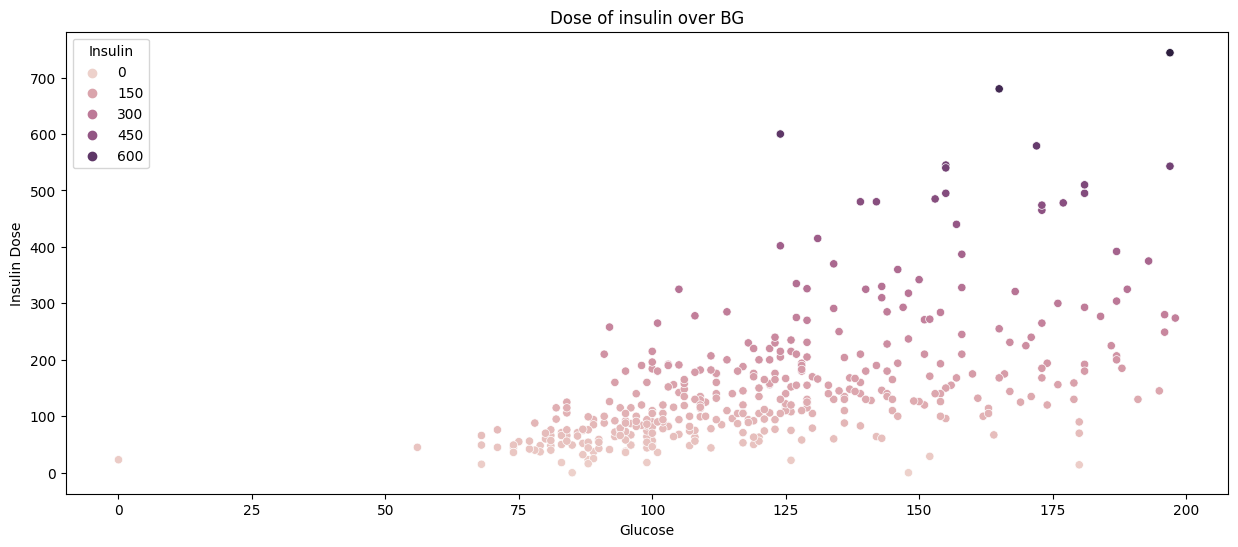

In [225]:
import seaborn as sns

# Plot means for training set
plt.figure(figsize=(15,6))
sns.scatterplot(data=inslin_data, x=inslin_data.Glucose,  y=inslin_data.Insulin,hue=inslin_data.Insulin)
plt.title('Dose of insulin over BG')
plt.xlabel('Glucose')
plt.ylabel('Insulin Dose')
plt.show()



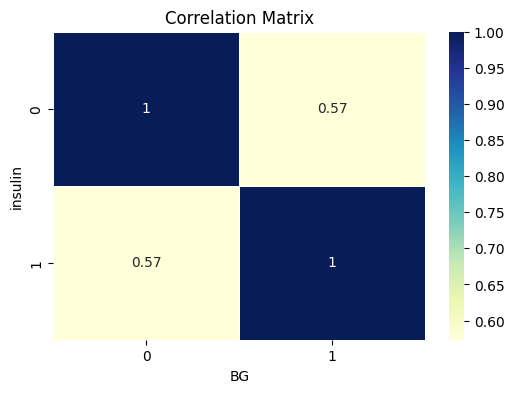

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt


# Define the correlation matrix
corr_inslin_data = inslin_data.corr()
corr_matrix = np.array(corr_inslin_data)

# Create a heatmap plot
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True,linewidths=.5,cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.xlabel('BG')
plt.ylabel('insulin')
plt.show()

In [268]:
X_features = inslin_data[['Glucose']].values
y_lables = inslin_data[['Insulin']].values

# Preprocesse Data
scaler = MinMaxScaler(feature_range=(0,1))
X_features = scaler.fit_transform(X_features)
scaler_ = MinMaxScaler(feature_range=(0,1))
y_lables = scaler_.fit_transform(y_lables)
y_lables = y_lables.reshape(396)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_lables, test_size=0.3, random_state=0)

print("X_train shape : ",X_train.shape)
print("X_test shape : ",X_test.shape)
print("y_train shape : ",y_train.shape)
print("y_test shape : ",y_test.shape)
print("X_features shape : ",X_features.shape)

X_train shape :  (277, 1)
X_test shape :  (119, 1)
y_train shape :  (277,)
y_test shape :  (119,)
X_features shape :  (396, 1)


In [191]:
y_test

array([1.29411765, 0.56470588, 1.25882353, 0.19607843, 0.36862745,
       0.70588235, 0.84313725, 0.56862745, 0.        , 0.71764706,
       0.30980392, 0.36862745, 0.20784314, 0.47058824, 0.29803922,
       0.54901961, 1.09019608, 0.70588235, 0.50980392, 0.20392157,
       0.22745098, 0.41176471, 0.22745098, 0.41176471, 0.81176471,
       0.43137255, 0.35294118, 1.45098039, 0.52941176, 0.50980392,
       0.47058824, 0.41176471, 1.7254902 , 0.30588235, 0.65098039,
       0.47058824, 0.2       , 0.66666667, 0.7254902 , 0.90196078,
       0.65882353, 0.07058824, 1.14901961, 0.50980392, 0.43137255,
       0.70588235, 1.2745098 , 0.49019608, 1.28627451, 0.61176471,
       0.47843137, 1.8745098 , 0.14509804, 0.57254902, 0.43137255,
       0.15686275, 0.82352941, 0.23529412, 0.98039216, 0.32156863,
       0.74509804, 0.50980392, 0.21176471, 0.36862745, 0.41568627,
       0.68627451, 0.17254902, 0.45098039, 0.3254902 , 0.41176471,
       0.24705882, 0.32156863, 1.09803922, 1.03921569, 0.18039

In [269]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [270]:
coeff_df = pd.DataFrame(regressor.coef_, ["BG"], columns=['Coefficient'])
coeff_df

,Coefficient
BG,0.523712


In [271]:
y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("y_pred shape : ",y_pred.shape)
df.head(20)

y_pred shape :  (119,)


,Actual,Predicted
0,0.443548,0.265222
1,0.193548,0.251996
2,0.431452,0.331347
3,0.067204,0.151486
4,0.126344,0.199096
5,0.241935,0.267867
6,0.288978,0.214966
7,0.194892,0.196451
8,0.000000,0.111811
9,0.245968,0.225546


In [272]:
print('Accuracy of The Model on test set: {:.2f}'.format(regressor.score(X_test, y_test)))
print('Cost/Loss Function (MSE): {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))

Accuracy of The Model on test set: 0.48
Cost/Loss Function (MSE): 0.01


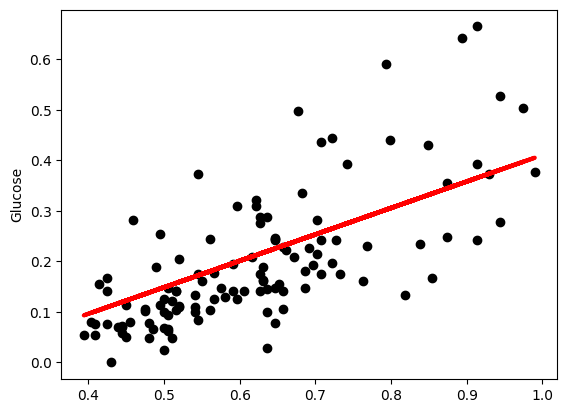

In [273]:
import matplotlib.pyplot as  plt

# plt.title('Hours vs Percentage')
plt.ylabel('Insulin Dose')
plt.ylabel('Glucose')

plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="red", linewidth=3)
plt.show()

In [274]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "Insulin_pred.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(regressor, file)


Pipline

In [285]:
def InsuDose_Pipline(input_data):

  input_data = np.array(input_data).reshape(-1,1)
  print(input_data.shape)

  # Feature scaling
  scaler = MinMaxScaler(feature_range = (0,1))
  Glucose_act = scaler.fit_transform(input_data)

  # load model's metadata

  with open('/content/Insulin_pred.pkl', 'rb') as file:
      loaded_model = pickle.load(file)

  Insulin_pred = regressor.predict(Glucose_act)

  Insulin_pred = np.array(Insulin_pred).reshape(-1,1)


  #Inverse transform predictions
  BG_pred = scaler.inverse_transform(Insulin_pred)

  return BG_pred.reshape(1)[0]

InsuDose_Pipline(178)

(1, 1)


177.88698524799585